In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from pygsp import *
from networkx import is_tree
import networkx as nx

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (5, 4)

### Import temperature and latitude datasets


In [2]:
Temp = pd.read_csv('..\Graph Signal Processing\Temperature.csv')
Lat = pd.read_csv('..\Graph Signal Processing\Latitude.csv')
Temp.shape, Lat.shape

((48, 2), (48, 5))

In [3]:
# collect data in a single dataframe
df = Lat.copy()
df['Temperature'] = Temp['Avg F']
# save the file
df.to_csv('..\Graph Signal Processing\data.csv')

# -------for descibing the positon of nodes-----
pos_array=df[['Longitude','Latitude']].values
pos_dict = {}
for key,(i,j) in enumerate(pos_array):
    pos_dict[key] =  [i,j]
# ---------------------------------------------
df[:5]

,State,Abbr,Bordering States,Latitude,Longitude,Temperature
0,Alabama,AL,"Florida, Georgia, Mississippi, Tennessee",32.806671,-86.791130,62.8
1,Arizona,AZ,"California, Colorado, Nevada, New Mexico, Utah",33.729759,-111.431221,60.3
2,Arkansas,AR,"Louisiana, Mississippi, Missouri, Oklahoma, Te...",34.969704,-92.373123,60.4
3,California,CA,"Arizona, Nevada, Oregon",36.116203,-119.681564,59.4
4,Colorado,CO,"Arizona, Kansas, Nebraska, New Mexico, Oklahom...",39.059811,-105.311104,45.1


In [4]:
# A directed edge between states is assigned based on latitudes; from lower to higher.

# The corresponding adjacency matrces are 
directed_adj = np.zeros((df.shape[0],df.shape[0]))
undirected_adj = np.zeros((df.shape[0],df.shape[0]))
symm_adj = np.zeros((df.shape[0],df.shape[0]))

for i, row in df.iterrows():
    latitute = row['Latitude']
#     print(row['Bordering States'])
    for state in row['Bordering States'].split(','):
        if state[0]==' ':
            state = state[1:]
#         print(state)
#         print(df[df['State'] == state]['Latitude'].values[0])
        undirected_adj[i][df[df['State'] == state].index[0]] = 1
        if latitute <= df[df['State'] == state]['Latitude'].values[0]:
            directed_adj[i][df[df['State'] == state].index[0]] = 1

            
# defining the symmetrized adj
for i in range(symm_adj.shape[0]):
    for j in range(symm_adj.shape[1]):
        symm_adj[i][j] = 0.5*(directed_adj[i][j]+directed_adj[j][i])
        
# define the degree matrix
D = np.diag(np.sum(undirected_adj,-1)**(-0.5))

directed_adj[:5,:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [5]:
np.sum(directed_adj, -1)
# 16,31,42,44 - no edge points from them to other states 

array([2., 5., 3., 2., 3., 3., 2., 2., 3., 3., 3., 3., 3., 2., 6., 2., 0.,
       2., 2., 2., 1., 3., 4., 1., 3., 3., 2., 2., 3., 2., 2., 0., 2., 3.,
       1., 1., 2., 1., 3., 3., 4., 2., 0., 2., 0., 3., 1., 3.])

In [6]:
df[df.index == 31]

,State,Abbr,Bordering States,Latitude,Longitude,Temperature
31,North Dakota,ND,"Minnesota, Montana, South Dakota",47.528912,-99.784012,40.4


#### Creating the Undirected  and Directed Graphs

48 nodes, 110 edges
True


Text(0.5, 1.0, '')

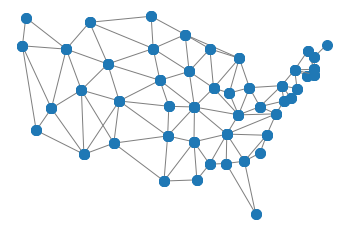

In [7]:
# create the graph using the Adjacency matrices
G_gsp_dir = graphs.Graph(directed_adj)
G_gsp_undir = graphs.Graph(undirected_adj)
print('{} nodes, {} edges'.format(G_gsp_dir.N, G_gsp_dir.Ne))
print(G_gsp_dir.is_directed())
G_gsp_dir.set_coordinates(kind=pos_array,labels=df['Abbr'].to_dict(),with_label = True)
G_gsp_undir.set_coordinates(kind=pos_array,labels=df['Abbr'].to_dict(),with_label = True)
G_gsp_dir.plot()
plt.axis('off')
plt.title('')

## Signal Denoising

#### Undirected Case

In [8]:
G_gsp_undir.compute_laplacian('normalized')
G_gsp_undir.compute_fourier_basis(recompute=True) 
# G_gsp_undir.U
G_gsp_undir.L.todense()[:5,:5]

matrix([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.        ,  0.        , -0.25819889, -0.16903085],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
        [ 0.        , -0.25819889,  0.        ,  1.        ,  0.        ],
        [ 0.        , -0.16903085,  0.        ,  0.        ,  1.        ]])

#### Plotting the signal

Text(0.5, 1.0, '')

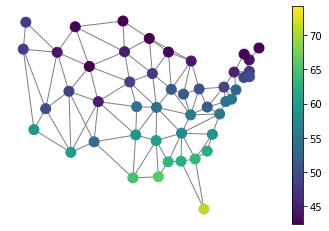

In [9]:
G_gsp_dir.plot_signal(df['Temperature'].values)
plt.axis('off')
plt.title('')

#### Gain Case

In [10]:
q_gain = 0.02

# defining the gain adjacency matrix
def gain_adj(q):
    adj = np.zeros((df.shape[0],df.shape[0]),dtype=complex)
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
#             if undirected_adj[i][j]==1:
            adj[i][j] = np.exp(2*(np.pi)*q*1j*(directed_adj[i][j]-directed_adj[j][i]))
    return adj

gain_lapl = np.identity(df.shape[0]) - D@np.multiply(gain_adj(q_gain),undirected_adj)@D

# calculate fourier basis
eigenValues_gain,U_gain = np.linalg.eigh(gain_lapl)

gain_lapl[:5,:5]

array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [ 0.        +0.j        ,  1.        +0.j        ,
         0.        +0.j        , -0.25616291-0.0323609j ,
        -0.16769799-0.02118518j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [ 0.        +0.j        , -0.25616291+0.0323609j ,
         0.        +0.j        ,  1.        +0.j        ,
         0.        +0.j        ],
       [ 0.        +0.j        , -0.16769799+0.02118518j,
         0.        +0.j        ,  0.        +0.j        ,
         1.        +0.j        ]])

#### Hermitian Case

In [11]:
q_hermitian = 0.02
hermitian_lapl = np.identity(df.shape[0]) - D@np.multiply(gain_adj(q_hermitian),symm_adj)@D

# calculate fourier basis
eigenValues_hermitian,U_hermitian = np.linalg.eigh(hermitian_lapl)

hermitian_lapl[:5,:5]

array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [ 0.        +0.j        ,  1.        +0.j        ,
         0.        +0.j        , -0.12808146-0.01618045j,
        -0.083849  -0.01059259j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [ 0.        +0.j        , -0.12808146+0.01618045j,
         0.        +0.j        ,  1.        +0.j        ,
         0.        +0.j        ],
       [ 0.        +0.j        , -0.083849  +0.01059259j,
         0.        +0.j        ,  0.        +0.j        ,
         1.        +0.j        ]])

In [12]:
eigenValues_hermitian

array([0.50077633, 0.51500135, 0.53901922, 0.56851522, 0.59753825,
       0.62208952, 0.66891459, 0.70253889, 0.71206128, 0.76053245,
       0.78464054, 0.79715146, 0.82916575, 0.87453309, 0.8858928 ,
       0.92072108, 0.9460619 , 0.95350261, 0.97907014, 0.99280201,
       1.02257456, 1.03389503, 1.04558679, 1.07412327, 1.08605165,
       1.09152993, 1.1128208 , 1.12412514, 1.13469558, 1.1426988 ,
       1.15151539, 1.16089393, 1.16452671, 1.16859506, 1.17393107,
       1.18671136, 1.19976823, 1.20231696, 1.20734042, 1.22010531,
       1.23044687, 1.2365302 , 1.25654338, 1.26163006, 1.26707456,
       1.268677  , 1.27401453, 1.35074893])

### Calculating Errors

In [13]:
# adding noise to the signal
e_undir= np.zeros(df.shape[0])
e_hermitian = np.zeros(df.shape[0])
e_gain = np.zeros(df.shape[0])

# Temperature signals on different graphs
denoised_signal_undir = np.zeros(df.shape[0])
denoised_signal_gain = np.zeros(df.shape[0])
denoised_signal_hermitian = np.zeros(df.shape[0])

# number of simulations
sim = 100

# define the low pass filter kernel
c=2
def filter(eigen):
    return 1/(1+c*eigen)



# permoing sim number of simulations
for i in range(sim):
    noise = np.random.normal(loc = 0,scale=10,size=df.shape[0])
    noised_temp  = noise+df['Temperature'].values

    # denoised signal for undirected case
    H = np.diag(filter(G_gsp_undir.e))
    denoised_signal_undir = np.real(G_gsp_undir.U@H@G_gsp_undir.U.T@noised_temp)
    # Error for undirected case
    e_undir += (1/sim)*np.abs(denoised_signal_undir-df['Temperature'].values)
    
    # denoised signal for hermitian case
    H = np.diag(filter(eigenValues_hermitian))
    denoised_signal_hermitian = np.real(U_hermitian@H@(np.conjugate(U_hermitian).T)@noised_temp)
    # Error for hermitian case
    e_hermitian += (1/sim)*np.abs(denoised_signal_hermitian-df['Temperature'].values)
    
    # denoised signal for Gain case
    H = np.diag(filter(eigenValues_gain))
    denoised_signal_gain = np.real(U_gain@H@np.conjugate(U_gain).T@noised_temp)
    # Error for Gain case
    e_gain += (1/sim)*np.abs(denoised_signal_gain-df['Temperature'].values)
    
e_undir

array([ 3.5516313 ,  5.65561997,  4.30296375, 11.8083171 , 10.04425557,
        5.36589397,  7.77488726, 18.69733958,  5.11496682,  7.87439768,
        3.29930439,  5.91929532,  3.40937259,  6.58039192,  4.21514406,
       11.82685673, 10.6584666 ,  3.88302252,  6.21171687,  3.82746505,
        4.46243344,  5.4001318 ,  6.83787533,  3.2109597 ,  3.41425601,
        3.68977973,  4.06979991,  7.08252709,  3.51483253, 10.60235262,
        4.30251752,  4.35118284,  3.14938999,  3.47290663,  3.47683934,
        7.98236028,  5.97409111, 14.0033951 ,  3.88829082, 11.90405058,
        7.83170557,  4.82589597,  3.73144935,  3.32429644, 10.33486783,
        2.93977234,  3.16026883,  6.30072641])

In [14]:
# comapring the averages
np.average(e_gain),np.average(e_hermitian),np.average(e_undir)

(6.208601526120488, 26.372777346743703, 6.192922170246452)

### create the barplots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


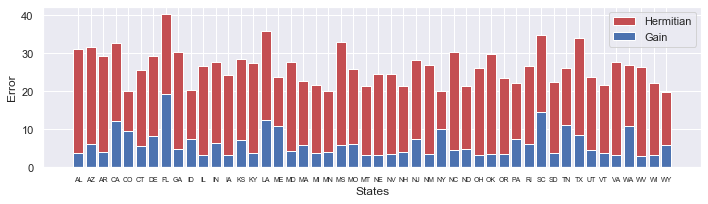

In [26]:
plt.figure(figsize =(10, 3)) 
# plt.bar(xticks, e_undir)
sns.set(palette = 'deep')
xticks = [i for i in range(df.shape[0])]
plt.bar(xticks, e_hermitian, color='r')
plt.bar(xticks, e_gain)
plt.xticks(xticks,labels=df['Abbr'].to_list(),fontsize=7)
plt.axis('tight')
plt.ylabel("Error")
plt.xlabel("States")
plt.legend(['Hermitian','Gain'])
plt.tight_layout()
plt.savefig('..\Graph Signal Processing\Images\Error_Barplot.eps',format='eps',dps=200)
plt.show()

### Drawing directed graph using NetworkX

In [16]:
# G_nx = nx.to_networkx_graph(directed_adj, create_using=nx.DiGraph)
# plt.figure(figsize =(8, 5)) 
# plt.tight_layout()

# # ------------
# pos_array=df[['Longitude','Latitude']].values
# pos_dict = {}
# for key,(i,j) in enumerate(pos_array):
#     pos_dict[key] =  [i,j]
# # ------------

# nx.draw_networkx(G_nx,pos=pos_dict, labels=df['Abbr'].to_dict(),with_label = True, node_color = range(48)) 
# plt.savefig('..\Graph Signal Processing\Images\Temp_directed_graph.png',format='png',dpi=200)

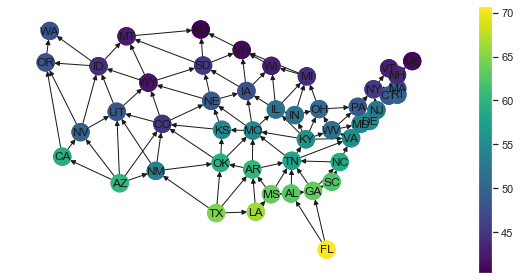

In [39]:
G_nx = nx.to_networkx_graph(directed_adj, create_using=nx.DiGraph)
plt.figure(figsize =(8, 4)) 

nc = nx.draw_networkx_nodes(G_nx, pos=pos_dict, label=df['Abbr'].to_dict(), with_label = True, 
                            node_color=df['Temperature'].values,cmap=plt.cm.viridis)
nx.draw_networkx(G_nx,pos=pos_dict, labels=df['Abbr'].to_dict(),with_label = True, 
                 node_color=df['Temperature'].values,cmap=plt.cm.viridis) 

plt.colorbar(nc)
plt.tight_layout()
plt.box(False)
plt.savefig('..\Graph Signal Processing\Images\Temp_directed_graph.eps',format='eps',dpi=200)

### Drawing Undirected graph using NetworkX

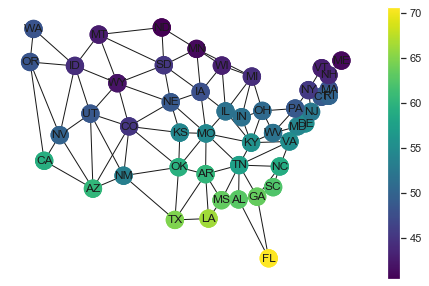

In [38]:
G_nx = nx.to_networkx_graph(undirected_adj)
plt.figure(figsize =(8, 5)) 
plt.tight_layout()

nc = nx.draw_networkx_nodes(G_nx, pos=pos_dict, label=df['Abbr'].to_dict(), with_label = True, 
                            node_color=df['Temperature'].values,cmap=plt.cm.viridis)
nx.draw_networkx(G_nx,pos=pos_dict, labels=df['Abbr'].to_dict(),with_label = True, 
                 node_color=df['Temperature'].values,cmap=plt.cm.viridis) 

plt.colorbar(nc)
plt.box(False)
# plt.savefig('..\Graph Signal Processing\Images\Temp_directed_graph.png',format='png',dpi=200)

In [19]:
# ec = nx.draw_networkx_edges(G_nx, pos=pos_dict, alpha=0.2)
# nc = nx.draw_networkx_nodes(G_nx, pos=pos_dict, label=df['Abbr'].to_dict(), with_label = True, 
#                             node_color=df['Temperature'].values)
# plt.colorbar(nc)
# plt.axis('off')
# plt.show()

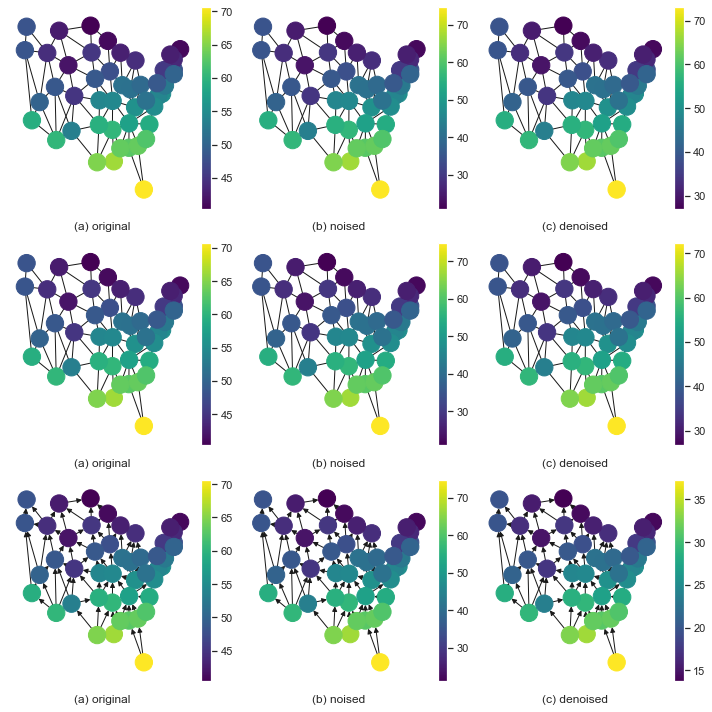

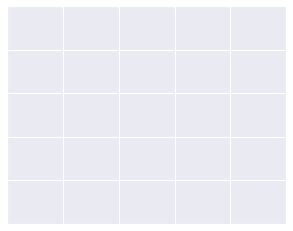

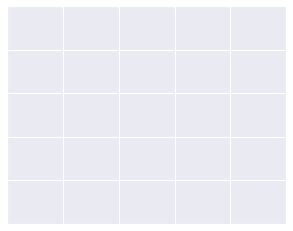

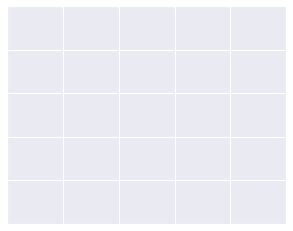

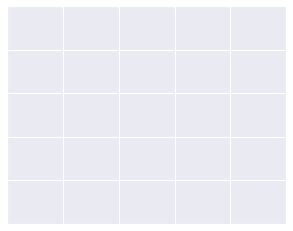

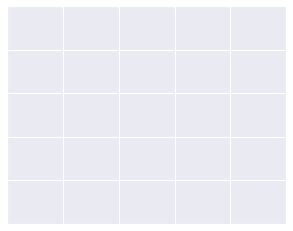

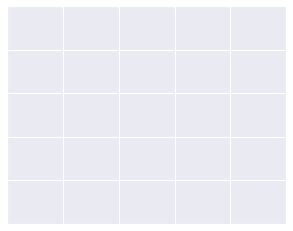

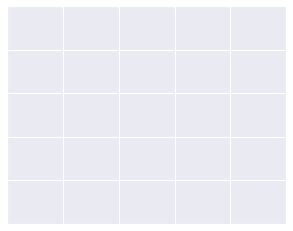

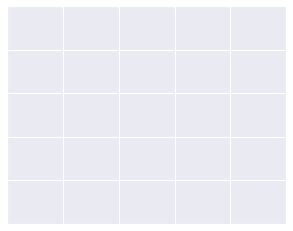

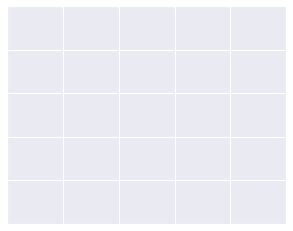

In [40]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['(a) original','(b) noised','(c) denoised']
graph_type = ['G_gsp_undir','G_gsp_dir','G_gsp_dir']
signals = [[df['Temperature'].values,noised_temp,denoised_signal_undir],
           [df['Temperature'].values,noised_temp,denoised_signal_gain],
           [df['Temperature'].values,noised_temp,denoised_signal_hermitian]]
# denoised_signals = ['denoised_signal_undir','denoised_signal_gain','denoised_signal_hermitian']
f,axes = plt.subplots(3,3,figsize = (10,10))
row,col = 0,0
while row < 3:
    plt.figure(figsize=(5, 4))
    if row==2:
        G_nx = nx.to_networkx_graph(directed_adj, create_using=nx.DiGraph)
        nc = nx.draw_networkx_nodes(G_nx, pos=pos_dict,node_color=signals[row][col],cmap=plt.cm.viridis,
                                    ax = axes[row,col],node_size=100)
        nx.draw_networkx(G_nx,pos=pos_dict, node_color=df['Temperature'].values,cmap=plt.cm.viridis,ax = axes[row,col],
                        with_labels=False) 

        divider = make_axes_locatable(axes[row,col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        f.colorbar(nc, cax=cax, orientation='vertical')
        axes[row,col].set_yticklabels('')
        axes[row,col].set_xticklabels('')
        axes[row,col].set_xlabel(labels[col])
        axes[row,col].set(frame_on=False)
#         axes[row,col].set_title('')
        col+=1
    else:
        G_nx = nx.to_networkx_graph(undirected_adj)
        nc = nx.draw_networkx_nodes(G_nx, pos=pos_dict,node_color=signals[row][col],cmap=plt.cm.viridis,
                                    ax = axes[row,col],node_size=100)
        nx.draw_networkx(G_nx,pos=pos_dict, node_color=df['Temperature'].values,cmap=plt.cm.viridis,ax = axes[row,col],
                         with_labels=False) 

        divider = make_axes_locatable(axes[row,col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        f.colorbar(nc, cax=cax, orientation='vertical')
        axes[row,col].set_yticklabels('')
        axes[row,col].set_xticklabels('')
        axes[row,col].set_xlabel(labels[col])
        axes[row,col].set(frame_on=False)
#         axes[row,col].set_title('')
        col+=1
        
    if col==3:
        row+=1
        col=0

f.tight_layout()
f.savefig('..\Graph Signal Processing\Images\graph_subplots.eps',format='eps',dpi=200)
plt.show()

### Drawing the Graphs using PyGSP

Text(0.5, 1.0, '')

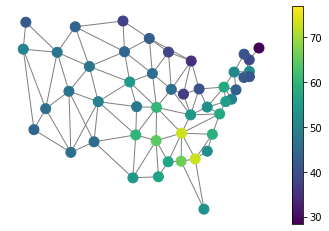

In [21]:
# Denoised Undirected 
# G_gsp_undir.set_coordinates(kind=df[['Longitude','Latitude']].values,labels=df['Abbr'].to_dict(),with_label = True)
G_gsp_undir.plot_signal(denoised_signal_undir)
plt.axis('off')
plt.title('')

Text(0.5, 1.0, '')

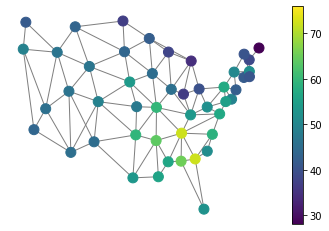

In [22]:
# Denoised Gain 
# G_gsp_dir.set_coordinates(kind=df[['Longitude','Latitude']].values,labels=df['Abbr'].to_dict(),with_label = True)
G_gsp_dir.plot_signal(denoised_signal_gain)
plt.axis('off')
plt.title('')

Text(0.5, 1.0, '')

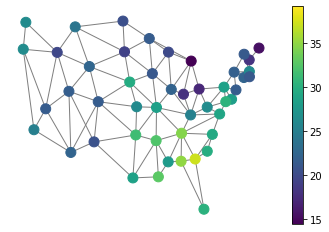

In [23]:
# Denoised Hermitian 
G_gsp_dir.plot_signal(denoised_signal_hermitian)
plt.axis('off')
plt.title('')

### Subplots

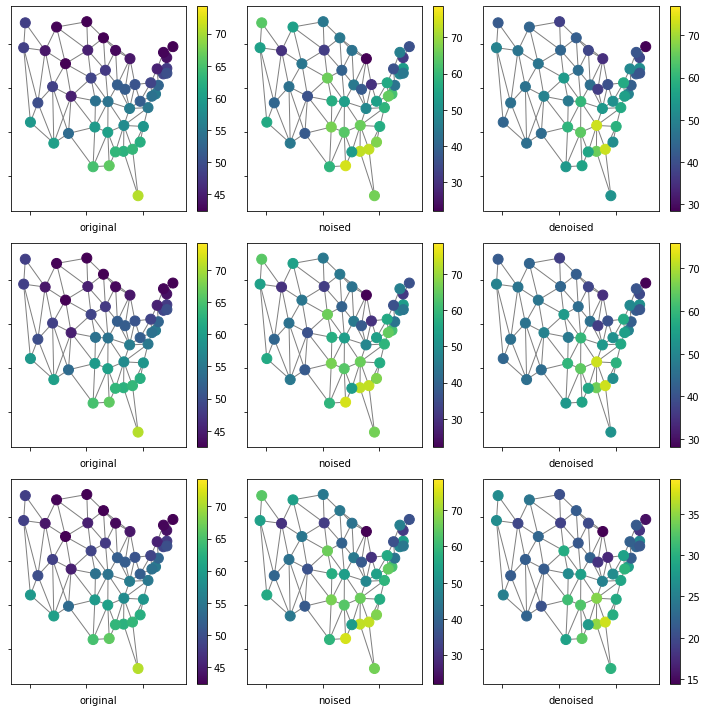

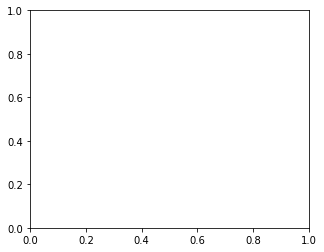

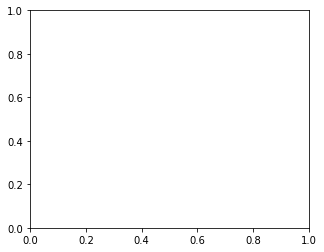

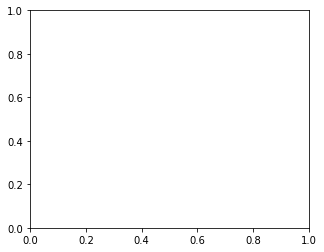

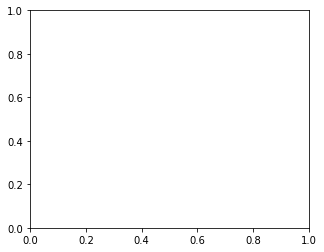

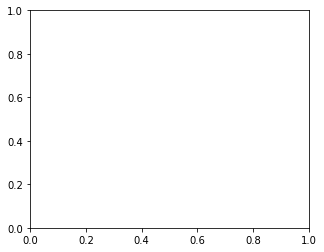

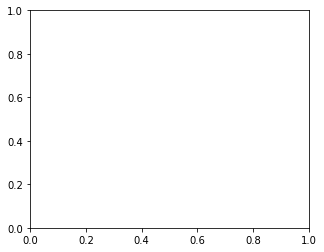

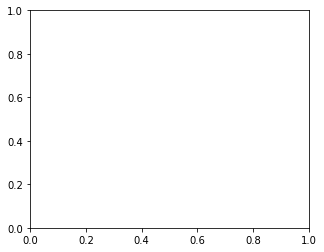

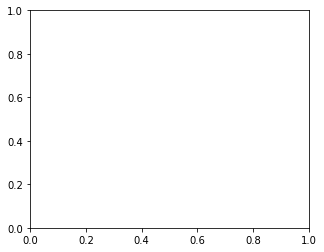

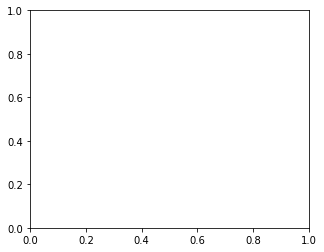

In [24]:
%matplotlib inline
labels = ['original','noised','denoised']
graph_type = ['G_gsp_undir','G_gsp_dir','G_gsp_dir']
signals = [[df['Temperature'].values,noised_temp,denoised_signal_undir],
           [df['Temperature'].values,noised_temp,denoised_signal_gain],
           [df['Temperature'].values,noised_temp,denoised_signal_hermitian]]
# denoised_signals = ['denoised_signal_undir','denoised_signal_gain','denoised_signal_hermitian']
f,axes = plt.subplots(3,3,figsize = (10,10))
row,col = 0,0
while row < 3:
    plt.figure(figsize=(5, 4))
    if row==2:
        G_gsp_dir.plot_signal(signals[row][col],ax = axes[row,col])
        axes[row,col].set_yticklabels('')
        axes[row,col].set_xticklabels('')
        axes[row,col].set_xlabel(labels[col])
        axes[row,col].set_title('')
        col+=1
    else:
        G_gsp_undir.plot_signal(signals[row][col],ax = axes[row,col])
        axes[row,col].set_yticklabels('')
        axes[row,col].set_xticklabels('')
        axes[row,col].set_xlabel(labels[col])
        axes[row,col].set_title('')
        col+=1
        
    if col==3:
        row+=1
        col=0

f.tight_layout()
# f.savefig('..\Graph Signal Processing\Images\graph_subplots.png',format='png',dpi=200)
plt.show()

### Selecting q based on fundamental cycles

In [25]:
G_nx = nx.to_networkx_graph(undirected_adj)
cycle_basis_list = nx.cycle_basis(G_nx, 0)
def cycle_gain():
    cycle_sum = 0
    for cycle in cycle_basis_list:
        cycle_gain = 1
        for i in range(len(cycle)):
            cycle_gain *= np.exp(2*(np.pi)*q*1j*(directed_adj[cycle[i]][cycle[i]+1]-directed_adj[cycle[i]+1][cycle[i]]))